<a href="https://colab.research.google.com/github/Anushkasethi/APS360_Labs/blob/main/Lab4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Monday, July 11 at 5:00 PM

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Justin Beland <justin.beland@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1c5LS805BpzgeECn0J0oC5_29xe1eUVdt?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
print('Max:', (df['age']).max())
print('Min:', (df['age']).min())
print('Avg:', (df['age']).mean())


Max: 90
Min: 17
Avg: 38.58164675532078


In [ ]:
print('Max:', (df['yredu']).max())
print('Min:', (df['yredu']).min())
print('Avg:', (df['yredu']).mean())

Max: 16
Min: 1
Avg: 10.0806793403151


In [ ]:
print('Max:', (df['capgain']).max())
print('Min:', (df['capgain']).min())
print('Avg:', (df['capgain']).mean())

Max: 99999
Min: 0
Avg: 1077.6488437087312


In [ ]:
print('Max:', (df['caploss']).max())
print('Min:', (df['caploss']).min())
print('Avg:', (df['caploss']).mean())

Max: 4356
Min: 0
Avg: 87.303829734959


In [ ]:
print('Max:', (df['workhr']).max())
print('Min:', (df['workhr']).min())
print('Avg:', (df['workhr']).mean())

Max: 99
Min: 1
Avg: 40.437455852092995


Normalize features:

In [ ]:
df["age"] = (df["age"]-(df['age']).min()) / ((df['age']).max() - (df['age']).min())
df["yredu"] = (df["yredu"]-(df['yredu']).min()) / ((df['yredu']).max() - (df['yredu']).min())
df["capgain"] = (df["capgain"]-(df['capgain']).min()) / ((df['capgain']).max() - (df['capgain']).min())
df["caploss"] = (df["caploss"]-(df['caploss']).min()) / ((df['caploss']).max() - (df['caploss']).min())
df["workhr"] = (df["workhr"]-(df['workhr']).min()) / ((df['workhr']).max() - (df['workhr']).min())

Verification that features have been normalized:

In [ ]:
print('Max:', (df['workhr']).max())
print('Min:', (df['workhr']).min())
print('Avg:', (df['workhr']).mean())

Max: 1.0
Min: 0.0
Avg: 0.40242301889890814


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
male= sum(df["sex"] == " Male")

In [ ]:
fem = sum(df["sex"] == " Female")

In [ ]:
total = sum(df["sex"] == " Female") + sum(df["sex"] == " Male")

Percentage of people who are male:

In [ ]:
(male/total)*100

66.92054912318419

Percentage of people who are female:

In [ ]:
(fem/total)*100

33.07945087681583

### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]  #Wt exactly is happening here?
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]  #how can we get to know which column heading this has? Is it like below?
df_not_missing = df[~missing]

In [ ]:
print(df_not_missing.columns)

Index(['age', 'yredu', 'capgain', 'caploss', 'workhr', 'work', 'marriage',
       'occupation', 'edu', 'relationship', 'sex'],
      dtype='object')


Number of records which contained missing features:

In [ ]:
missing = len(df_with_missing)
print(missing)

1843


In [ ]:
total = missing + len(df_not_missing)
print(total)

32561


The percentage of records removed:

In [ ]:
print((missing/total)*100)

5.660145572924664


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing["age"])) #what does this signify?? --> age is not categorical hence it shows up the values instead of all the classes!

{0.3013698630136986, 0.4931506849315068, 0.1506849315068493, 0.2876712328767123, 0.4520547945205479, 0.273972602739726, 0.4383561643835616, 0.4794520547945205, 0.1917808219178082, 0.3424657534246575, 0.3150684931506849, 0.0, 1.0, 0.0684931506849315, 0.6301369863013698, 0.684931506849315, 0.7534246575342466, 0.5068493150684932, 0.3835616438356164, 0.821917808219178, 0.9452054794520548, 0.2602739726027397, 0.5753424657534246, 0.136986301369863, 0.6986301369863014, 0.0136986301369863, 0.3287671232876712, 0.7671232876712328, 0.8904109589041096, 0.2054794520547945, 0.0821917808219178, 0.5205479452054794, 0.6438356164383562, 0.3972602739726027, 0.7123287671232876, 0.8356164383561644, 0.0273972602739726, 0.4657534246575342, 0.589041095890411, 0.9041095890410958, 0.8767123287671232, 0.2191780821917808, 0.6575342465753424, 0.7808219178082192, 0.0958904109589041, 0.5342465753424658, 0.410958904109589, 0.8493150684931506, 0.9726027397260274, 0.1643835616438356, 0.8082191780821918, 0.6027397260273

In [ ]:
print(set(df_not_missing["work"])) 

{' Without-pay', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Private', ' State-gov', ' Self-emp-not-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(data.columns)

Index(['age', 'yredu', 'capgain', 'caploss', 'workhr', 'work_ Federal-gov',
       'work_ Local-gov', 'work_ Private', 'work_ Self-emp-inc',
       'work_ Self-emp-not-inc', 'work_ State-gov', 'work_ Without-pay',
       'marriage_ Divorced', 'marriage_ Married-AF-spouse',
       'marriage_ Married-civ-spouse', 'marriage_ Married-spouse-absent',
       'marriage_ Never-married', 'marriage_ Separated', 'marriage_ Widowed',
       'occupation_ Adm-clerical', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving', 'edu_ 10th',
       'edu_ 11th', 'edu_ 12th', 'edu_ 1st-4th', 'edu_ 5th-6th',
       'edu_ 7th-8th', 'edu_ 9th'

In [ ]:
print(len(data.columns))

57


We got 57 columns since using the get_dummies function divided the catergorical variables into seperate variables. For example as we can see above, since work is a categorical variable, it got split into 7 seperate columns each having their specific one-hot encoding depending on the category. Due to this we got a total of 57 columns.




### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature): #What exactly is this doing?
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [ ]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html

np.random.seed(50)

# todo

index = np.arange(len(data))
np.random.shuffle(index)
data1 = int(len(index) * 0.7)
data2 = int(len(index) * 0.85)
train_index, val_index, test_index = index[:data1], index[data1:data2], index[data2:]
train_data = datanp[train_index]
valid_data = datanp[val_index]
test_data = datanp[test_index]

In [ ]:
print("Training data:", len(train_data))
print("Validation data:", len(valid_data))
print("Test data:", len(test_data))

Training data: 21502
Validation data: 4608
Test data: 4608


In [ ]:
train_data.dtype

dtype('float32')

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 45),
            nn.ReLU(),
            nn.Linear(45, 25)
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 45),
            nn.ReLU(),
            nn.Linear(45, 57),
            nn.ReLU(),
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The input data has been normalized and get_dummies function has also been used over the data, which means that the data lies between 0 and 1. Now we need to make sure that our output from the Autoencoder architecture defined by us is also matching the range of input data, hence we need to apply sigmoid activation in order for the output data to lie between 0 and 1.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib as plt
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_data, valid_data, batch_size = 128, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    train_loader = DataLoader(train_data, batch_size, shuffle = True,  num_workers = 2, pin_memory = True)
    valid_loader = DataLoader(valid_data, batch_size*2, num_workers = 2, pin_memory = True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss_val = criterion(recon, data)

        iters.append(epoch)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(float(loss_val)/batch_size)
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        print("Loss: ", train_loss[epoch-1], "epoch number ", epoch)

        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy

        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)


     # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

  


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch number  1 accuracy:  0.6025253464793973
Loss:  0.0005876771174371243 epoch number  0
epoch number  2 accuracy:  0.610400582891514
Loss:  0.0005876771174371243 epoch number  1
epoch number  3 accuracy:  0.6164387808885995
Loss:  0.0004316657723393291 epoch number  2
epoch number  4 accuracy:  0.6179735218429293
Loss:  0.00042832730105146766 epoch number  3
epoch number  5 accuracy:  0.6244070319040089
Loss:  0.00028911768458783627 epoch number  4
epoch number  6 accuracy:  0.6051917651071218
Loss:  0.00034721504198387265 epoch number  5
epoch number  7 accuracy:  0.6248798561374136
Loss:  0.00022243097191676497 epoch number  6
epoch number  8 accuracy:  0.6281973769881871
Loss:  0.00027417545788921416 epoch number  7
epoch number  9 accuracy:  0.6275152698973739
Loss:  0.00024891638895496726 epoch number  8
epoch number  10 accuracy:  0.6212677890428797
Loss:  0.00029304795316420496 epoch number  9


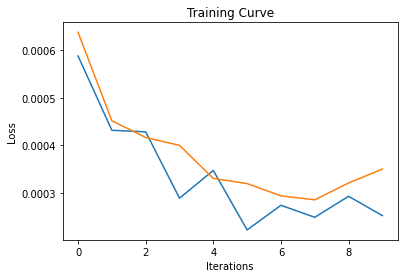

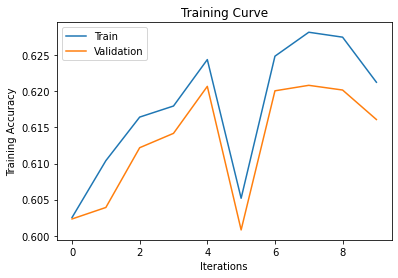

Final Training Accuracy: 0.6212677890428797
Final Validation Accuracy: 0.6161024305555556


In [ ]:
model = AutoEncoder()
train(model, train_data, valid_data, 64, 10, learning_rate=0.01)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

model_1:batch_size = 32, lr = 0.01, epochs = 20

Reasoning for model_1 hyperparameters: Looking at  model's accuracy of 62%, I decided to increase the number of epochs and decrease the batch size to check whether that will provide us with a better accuracy or not. Depending on what accuracy is obtained in this case, we will decide whether decreasing batch size was a good choice or not.

model_2:batch_size = 64, lr = 0.007, epochs = 20

Reasoning for model_2 hyperparameters: model_1 gave an accuracy of 60%, hence this means that decreasing the batch size was not a good idea, which is why I kept the batch size = 64 in this case (same as model), and experimented with the learning rate by decreasing it further since decreasing learning rate can prove to be beneficial at times. Having greater epochs is beneficial since it gives a good idea of what is going on compared to having smaller number of epochs. (from here I kept the learning rate and the number of epochs the same since they give better results)

model_3:batch_size = 128, lr = 0.007, epochs = 20

Reasoning for model_3 hyperparameters: model_2 gave an accuracy of 64% which is better than all the model's so far. Keeping the lr and epochs same, I decided to increase the batch size to a relatively larger number (128) to check if that will improve the accuracy. 

model_4:batch_size = 75, lr = 0.007, epochs = 20

Reasoning for model_4 hyperparameters: The accuracy of model_3 decreased to 63% which meant that 128 as a batch size was too large hence I changed batch_size to a value greater than 64 and comparitvely less than 128 choosing a safe value of 75.

model_5:batch_size = 85, lr = 0.007, epochs = 20

Reasoning for model_5 hyperparameters: model_4 gave the best accuracy uptill now by choosing batch size of 75, hence I wanted to see if I end up increasing batch size a bit more, if it would give me a comparitively better result. However, it was observed that increasing batch size to 85 reduced the accuarcy than when it was 75.

Hence, model_4 is the best model, as it gives a final accuracy of 65% greater than all the other models.


In [ ]:
def train_nocurves(model, train_data, valid_data, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters, losses, train_acc, val_acc = [], [], [], []

    epoch = 0
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        print("Loss: ", losses[epoch-1], "epoch number ", epoch)
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print("Final Training Accuracy: {}".format(train_acc[-1]))

In [ ]:
model_1 = AutoEncoder()
train_nocurves(model_1, train_data, valid_data, 32, 20, learning_rate=0.01)

epoch number  1 accuracy:  0.5973940408644157
Loss:  0.0010862095514312387 epoch number  0
epoch number  2 accuracy:  0.5963011192757263
Loss:  0.0010862095514312387 epoch number  1
epoch number  3 accuracy:  0.6078581837348463
Loss:  0.0007624005666002631 epoch number  2
epoch number  4 accuracy:  0.6018354881716429
Loss:  0.0008823206298984587 epoch number  3
epoch number  5 accuracy:  0.6153691129507333
Loss:  0.0005912362248636782 epoch number  4
epoch number  6 accuracy:  0.6186788825845658
Loss:  0.00046693041804246604 epoch number  5
epoch number  7 accuracy:  0.6045174092332496
Loss:  0.0006963965715840459 epoch number  6
epoch number  8 accuracy:  0.619624531051375
Loss:  0.0004341297026257962 epoch number  7
epoch number  9 accuracy:  0.608067466592255
Loss:  0.0007488076225854456 epoch number  8
epoch number  10 accuracy:  0.6230118128546182
Loss:  0.0005210385425016284 epoch number  9
epoch number  11 accuracy:  0.6205469258673612
Loss:  0.0004241600981913507 epoch number  

In [ ]:
model_2 = AutoEncoder()
train_nocurves(model_2, train_data, valid_data, 64, 20, learning_rate=0.007)

epoch number  1 accuracy:  0.6073698570675596
Loss:  0.0006000780267640948 epoch number  0
epoch number  2 accuracy:  0.6108036461724491
Loss:  0.0006000780267640948 epoch number  1
epoch number  3 accuracy:  0.6086100517781292
Loss:  0.0004552719765342772 epoch number  2
epoch number  4 accuracy:  0.6160512200415466
Loss:  0.00040524243377149105 epoch number  3
epoch number  5 accuracy:  0.6190354385638546
Loss:  0.00032958132214844227 epoch number  4
epoch number  6 accuracy:  0.6169348587728274
Loss:  0.0003268839209340513 epoch number  5
epoch number  7 accuracy:  0.6258720119058693
Loss:  0.00033357544452883303 epoch number  6
epoch number  8 accuracy:  0.6335302142436362
Loss:  0.0003387813630979508 epoch number  7
epoch number  9 accuracy:  0.6299414007999256
Loss:  0.00022901986085344106 epoch number  8
epoch number  10 accuracy:  0.631158341859672
Loss:  0.00029471542802639306 epoch number  9
epoch number  11 accuracy:  0.6292825473599355
Loss:  0.00023291161051020026 epoch nu

In [ ]:
model_3 = AutoEncoder()
train_nocurves(model_3, train_data, valid_data, 128, 20, learning_rate=0.007)

epoch number  1 accuracy:  0.5871469320683347
Loss:  0.0003579446056392044 epoch number  0
epoch number  2 accuracy:  0.6124003968623074
Loss:  0.0003579446056392044 epoch number  1
epoch number  3 accuracy:  0.603145443834682
Loss:  0.0003055966517422348 epoch number  2
epoch number  4 accuracy:  0.6190431897807955
Loss:  0.00020237790886312723 epoch number  3
epoch number  5 accuracy:  0.6189734288283261
Loss:  0.00020357301400508732 epoch number  4
epoch number  6 accuracy:  0.623376120050848
Loss:  0.0001617835514480248 epoch number  5
epoch number  7 accuracy:  0.6199810870306638
Loss:  0.0001487977133365348 epoch number  6
epoch number  8 accuracy:  0.6241202368771898
Loss:  0.00019629718735814095 epoch number  7
epoch number  9 accuracy:  0.6251278950795275
Loss:  0.00016121004591695964 epoch number  8
epoch number  10 accuracy:  0.6169193563389452
Loss:  0.00017048658628482372 epoch number  9
epoch number  11 accuracy:  0.6229032958174433
Loss:  0.00010983839456457645 epoch num

In [ ]:
model_4 = AutoEncoder()
train_nocurves(model_4, train_data, valid_data, 75, 20, learning_rate=0.007)

epoch number  1 accuracy:  0.5929138374724832
Loss:  0.0005288382371266682 epoch number  0
epoch number  2 accuracy:  0.6171673952810591
Loss:  0.0005288382371266682 epoch number  1
epoch number  3 accuracy:  0.6277710600564289
Loss:  0.0003880707422892253 epoch number  2
epoch number  4 accuracy:  0.6098114904039934
Loss:  0.0003295959532260895 epoch number  3
epoch number  5 accuracy:  0.6202368771897188
Loss:  0.0003337852656841278 epoch number  4
epoch number  6 accuracy:  0.6246860757138871
Loss:  0.00029587805271148683 epoch number  5
epoch number  7 accuracy:  0.6214848231172294
Loss:  0.0002756443868080775 epoch number  6
epoch number  8 accuracy:  0.6374678324496946
Loss:  0.0003094589213530223 epoch number  7
epoch number  9 accuracy:  0.6401032462096549
Loss:  0.0001945130651195844 epoch number  8
epoch number  10 accuracy:  0.6480559947911823
Loss:  0.0003167471786340078 epoch number  9
epoch number  11 accuracy:  0.648947384739404
Loss:  0.0001504583160082499 epoch number 

In [ ]:
model_5 = AutoEncoder()
train_nocurves(model_5, train_data, valid_data, 85, 20, learning_rate=0.007)

epoch number  1 accuracy:  0.5975800700710011
Loss:  0.0004911602858234855 epoch number  0
epoch number  2 accuracy:  0.6136870988745233
Loss:  0.0004911602858234855 epoch number  1
epoch number  3 accuracy:  0.6189889312622082
Loss:  0.0004151162855765399 epoch number  2
epoch number  4 accuracy:  0.6157101664961399
Loss:  0.0002443101037951077 epoch number  3
epoch number  5 accuracy:  0.6228490372988559
Loss:  0.0002405882319983314 epoch number  4
epoch number  6 accuracy:  0.6333286826031687
Loss:  0.0002500356558491202 epoch number  5
epoch number  7 accuracy:  0.6286236939199454
Loss:  0.00020980070180752697 epoch number  6
epoch number  8 accuracy:  0.630894800483676
Loss:  0.0001708987881155575 epoch number  7
epoch number  9 accuracy:  0.631034322388615
Loss:  0.00016393807223614524 epoch number  8
epoch number  10 accuracy:  0.6396691780609556
Loss:  0.0002809995675788206 epoch number  9
epoch number  11 accuracy:  0.639343626949431
Loss:  0.00022586150204434116 epoch number 

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
   
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
    return path

In [ ]:
batch_size=32

In [ ]:
test_DL = DataLoader(test_data, batch_size*2, num_workers = 2, pin_memory = True)

In [ ]:
model_path = get_model_name(model_4.name, batch_size=75, learning_rate=0.007, epoch=19)
state = torch.load(model_path)
model_4.load_state_dict(state)

<All keys matched successfully>

In [ ]:
test_accuracy = get_accuracy(model_4, test_DL)
print("test accuracy:", test_accuracy)

test accuracy: 0.6511140046296297


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
common = {}
for column in df_not_missing.columns:
  # get the most common value for each column
  common[column] = df_not_missing[column].value_counts().idxmax()

accuracy = sum(df_not_missing['marriage'] == common['marriage'])/len(df_not_missing)
print("The accuracy for baseline model of missing 'marriage' test is:", accuracy*100)

The accuracy for baseline model of missing 'marriage' test is: 46.67947131974738


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy obtained in part (a) as compared to part (b) is much better. The reason for this is that using an AutoEncoder as our model's architecture, it helps us extract the most important features of the data it sees and hence it learns more effectively therefore giving a better accuracy than the baseline model.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
get_features(test_data[0])

{'edu': 'Bachelors',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'work': 'Private'}

Yes I believe that it is reasonable for a human to guess someone's education level given other related features such as occupation, as it is somewhat related to the person's education level. For example, if a person has an occupation as a Prof-speciality, then it is reasonable to assume that the person has atleast done his/her masters. However, the unrelated features for example if they are married and what is the relationship status, based on just those factors, we might not be able to guess the eductaion level.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
var = zero_out_feature(torch.tensor(test_data[0]).view(1,57), "edu")
output = model_4(var).detach().numpy()#numpy array + remove gradient
print(get_feature(output[0],"edu")) #choosing education as we want to look at the education given other features

Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
print(common['edu'])

 HS-grad
